In [1]:
## As usual wiuth the starter code, my comments are marked with a ## while the starter comments have a single #

In [2]:
## This is in case you need this to run the rest of it. Feel free to comment out before you run 
## if you need this to run the sqlalchemy
## !pip install psycopg2

In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [73]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [6]:
# create engine to hawaii.sqlite
##getting the database path to grab the sqllite database
databasePath = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{databasePath}")

In [7]:
# reflect an existing database into a new model
## I believe this is where I would use the automap_base to map the sqlite file.
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()
## Measurement and station match up with the .csv files in the starter code so that makes sense

['measurement', 'station']

In [9]:
# Save references to each table
## Since the classes here are tables I save them as tables so I remember!
MeasurementTable = Base.classes.measurement
StationTable = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
## The session at the end is called session so I call it that
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
## This took me a while to get. It kept returning just the SQL command and not the data
## I forgot I needed the .first() at the end!

## the comma here gets rid of the comma in the printout. Makes it look nicer!
mostRecent, = session.query(MeasurementTable.date).order_by(MeasurementTable.date.desc()).first()
print(mostRecent)

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
## Thankfully we got that in the last section with mostRecent. Just need to filter it to all columns rather than .\
## just the date
lastDataPoint = session.query(MeasurementTable).order_by(MeasurementTable.date.desc()).first()

# Calculate the date one year from the last date in data set.
## This gets the date from one year prior
oneYearPrior = dt.date(2017,8,23) - dt.timedelta(days=365)
print(oneYearPrior)
# Perform a query to retrieve the data and precipitation scores
## This one shouldn't be too hard
yearQuery = session.query(MeasurementTable.date, MeasurementTable.prcp).filter(MeasurementTable.date >= \
                                                                               oneYearPrior)

In [102]:
## I split the cell here because it kept taking too long to run

# Save the query results as a Pandas DataFrame and set the index to the date column

## I used to not like pandas but sqlite makes me like going back to pandas. Nice and simple here.
## I did have to look up the "columns =" though. That part is cool I like that.

prcpDF = pd.DataFrame(yearQuery, columns = ["date", "prcp"])
## I like using new variables as to not screw with the data too much
prcpDated = prcpDF.set_index("date")

# Sort the dataframe by date
sortedDF = prcpDated.sort_values("date")
sortedDF
# Use Pandas Plotting with Matplotlib to plot the data

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


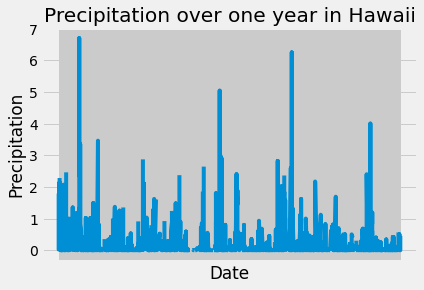

In [18]:
## I split the cell here for the same reason as the previous cell. Taking too long to run.

## I've learned that it's good to set the X and Y values first in case they need to be called again.
xValues = sortedDF.index.values
yValues = sortedDF["prcp"]

## By all accounts, this should be a line graph. I'm not sure why it's showing up as a bar.
plt.plot(xValues, yValues)
plt.title("Precipitation over one year in Hawaii")
## The dates at the bottom look terrible so I rotated them to be more legible.
## That didn't work so I found this tick_params argument to remove them entirely
plt.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sortedDF.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
## The stations table has a list of stations. All we need to do is count that
## I could have also accomplished this with 
stationCount = session.query(StationTable.station).count()
print(f'There are {stationCount} stations')

There are 9 stations


In [61]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

## This one is weird. To get both the counts on both the query and order by to get the correct counts and order
stationActivity =  session.query(MeasurementTable.station, func.count(MeasurementTable.date)).\
    group_by(MeasurementTable.station).order_by(func.count(MeasurementTable.date).desc()).all()
stationActivity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [116]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

## I could do a query for the station again but the list I got previously has the ID I need below
mostActive = stationActivity[0][0]

## I looked up and found the and_ addon and I like it so I used it here.

## The highest temp is found with a a filter by ordering the filter by descending it lets my get the highest temp \
## with a .first()
highestTemp = session.query(MeasurementTable.tobs).filter(and_(MeasurementTable.date >= \
                oneYearPrior, MeasurementTable.station == mostActive)).\
                order_by(MeasurementTable.tobs.desc()).first()

## The opposite is true for the lowest. I ordered not by descending so it let me get the lowest temp
lowestTemp = session.query(MeasurementTable.tobs).filter(and_(MeasurementTable.date >= \
                oneYearPrior, MeasurementTable.station == mostActive)).\
                order_by(MeasurementTable.tobs).first()

## Lastly I didn't need an order by, just a func.avg to find it.
averageTemp = session.query(func.avg(MeasurementTable.tobs)).filter(and_(MeasurementTable.date >= \
                oneYearPrior, MeasurementTable.station == mostActive)).first()
print(f'Highest temp is {highestTemp}.')
print(f'Lowest temp is {lowestTemp}.')
print(f'Average temp is {averageTemp}.')

Highest temp is 83.0.
Lowest temp is (59.0,).
Average temp is (73.10795454545455,).


In [107]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostActiveQuery = session.query(MeasurementTable.date, MeasurementTable.tobs).filter(and_(MeasurementTable.date >= \
                oneYearPrior, MeasurementTable.station == mostActive)).all()
mostActiveDF = pd.DataFrame(mostActiveQuery, columns = ["date", "tobs"])
sortedActiveDF = mostActiveDF.sort_values("date")
sortedActiveDF.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


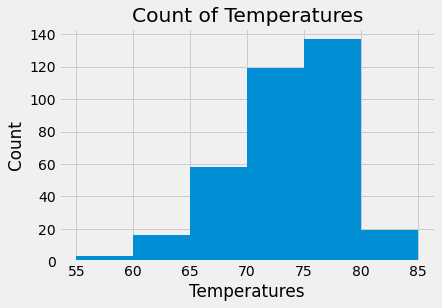

In [123]:
xValues = sortedActiveDF["tobs"]
bins = [55, 60, 65, 70, 75, 80, 85]
plt.hist(xValues, bins = bins)
plt.xlabel("Temperatures")
plt.ylabel("Count")
plt.title("Count of Temperatures")
plt.show()

# Close session

In [ ]:
# Close Session
## I'm glad the starter code remembered to this because I almost forgot!
session.close()